Лабораторна робота №2
Варіант 7

In [23]:
import os 
import time
import numpy  as np
from PIL import Image
import random 
import pandas as pd
import seaborn as sns
import cv2
import fbpca
from bisect import bisect_left
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.pylab as plt
from matplotlib import image as img

import scipy
from scipy import stats
from scipy.stats import iqr
from scipy.stats import skew,kurtosis
from scipy.stats import multivariate_normal as normal

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [4]:
path = '/users/yuliachornenko/downloads/mirflickr/im'
folder = os.path.join(os.getcwd(), 'mirflickr/')
images_sample = []
for i in random.sample(range(7,25001),250):
    images_sample.append(path + str(i) + '.jpg')
columns = ['num',
           'channel',
           'matspod',
           'disp',
           'skew',
           'kurt',
           'intens',
           'data']

1. Сформувати тестову вибірку зображень з вихідного пакета;
2. Для кожного каналу кольору кожного зображення з тестового пакета обчислити наступні характеристики: a. Математичне сподівання і дисперсію; b. Коефіцієнти асиметрії та ексцесу (нормалізований);

In [5]:
def do_open(file):  
    im = Image.open(file)
    return np.array(im)

def get_sample():
    t = time.time() 
    np_arrays = map(do_open, images_sample)
    array = [i for i in np_arrays]
    return array

def get_df(image):
    
    values = []
    for i in range(len(image)):
        temp = image[i]
        intens = (temp.sum(axis=0).sum(axis=0)/(temp.shape[0]*temp.shape[1]))/np.linalg.norm(temp.sum(axis=0).sum(axis=0)/(temp.shape[0]*temp.shape[1]), ord=None)
        for channel in range(3):
            channel_img = image[i][:,:,channel]
            values.append(list((random.sample(range(6,25001),250)[i], channel,
                                np.mean(channel_img),np.var(channel_img),
                                skew(channel_img, None), kurtosis(channel_img, None),
                                intens[channel],
                                channel_img)))
    
    return pd.DataFrame(values, columns=columns)

In [6]:
array = get_sample()
df = get_df(array)
df

,num,channel,matspod,disp,skew,kurt,intens,data
0,14791,0,118.344529,4141.369468,0.612615,-1.091253,0.628213,"[[68, 66, 67, 66, 66, 68, 68, 66, 65, 67, 69, ..."
1,5609,1,115.760384,4016.642789,0.726538,-0.878688,0.614496,"[[92, 90, 88, 87, 87, 89, 89, 88, 91, 91, 91, ..."
2,2143,2,89.900709,3987.556075,1.446758,0.872874,0.477224,"[[60, 58, 57, 56, 56, 56, 56, 52, 54, 55, 55, ..."
3,1049,0,66.506380,8841.404526,0.800390,-1.221777,0.520756,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,10540,1,71.822705,10128.912464,0.752074,-1.361379,0.562384,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...,...,...
745,17966,1,121.560976,3449.439786,0.694470,-0.868085,0.661303,"[[13, 11, 11, 12, 12, 13, 14, 15, 18, 19, 21, ..."
746,22642,2,88.980448,3587.328151,0.461932,-1.044352,0.484062,"[[14, 14, 16, 17, 15, 11, 9, 7, 4, 5, 7, 13, 1..."
747,7624,0,111.538859,3917.254325,0.145083,-0.731204,0.615495,"[[47, 39, 41, 37, 37, 29, 39, 32, 41, 37, 37, ..."
748,20019,1,102.536763,3521.345523,0.088060,-0.914847,0.565819,"[[42, 34, 37, 33, 36, 28, 40, 35, 46, 37, 33, ..."


3. Побудувати вектори параметрів зображень, що складаються з: a. Математичних очікувань значень яскравості для кожного каналу кольору; b. Математичних очікувань і дисперсії значень яскравості для кожного каналу кольору; c. Математичних очікувань, дисперсії і коефіцієнта асиметрії значень яскравості для кожного каналу кольору; d. Математичних очікувань, дисперсії, коефіцієнтів асиметрії та ексцесу значень яскравості для кожного каналу кольору;
4. Побудувати гаусові моделі зображень з використанням розрахованих раніше параметрів.

In [5]:
def get_vectors():
    
    ss = MinMaxScaler()
    df1 = df[['matspod','disp','skew','kurt','intens']]
    params = df1.columns
    ss.fit(df1)
    dfscal = pd.DataFrame(ss.transform(df1), columns=params)
    std = np.array(dfscal.std())
    cov = np.cov(dfscal.T)
    diag = np.eye(5,5) * np.array(dfscal.var())
    gauss_samples = np.random.multivariate_normal(std, diag, 750)
    plt.figure(5)
    plt.subplot('521')
    plt.plot(gauss_samples[:, 0], dfscal['matspod'], '.')
    plt.subplot('522')
    plt.plot(gauss_samples[:, 1], dfscal['disp'], '.')
    plt.subplot('523')
    plt.plot(gauss_samples[:, 2], dfscal['skew'], '.')
    plt.subplot('524')
    plt.plot(gauss_samples[:, 3], dfscal['kurt'], '.')
    plt.subplot('525')
    plt.plot(gauss_samples[:, 4], dfscal['intens'], '.')
    plt.show()
    
    print('normal')
    pgauss = normal.pdf(gauss_samples, std, diag)
    plt.figure(5)
    plt.subplot('521')
    plt.plot(gauss_samples[:, 0], pgauss, '.')
    plt.subplot('522')
    plt.plot(gauss_samples[:, 1], pgauss, '.')
    plt.subplot('523')
    plt.plot(gauss_samples[:, 2], pgauss, '.')
    plt.subplot('524')
    plt.plot(gauss_samples[:, 3], pgauss, '.')
    plt.subplot('525')
    plt.plot(gauss_samples[:, 4], pgauss, '.')
    plt.show()
    
    print('representation of the lower dimension')
    plt.plot(gauss_samples, pgauss) 
    plt.show()

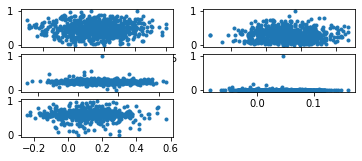

normal


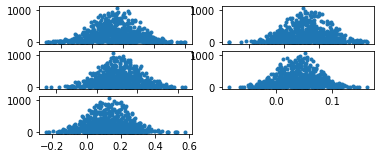

representation of the lower dimension


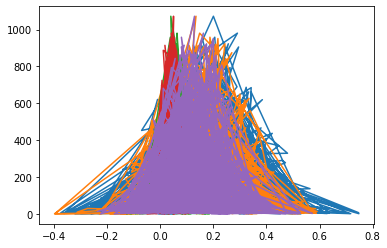

In [6]:
get_vectors()

5. Провести декомпозицію кожного каналу кольору кожного зображення з застосуванням методу головних компонент (PCA): a. Варіюючи кількість компонент, провести реконструкцію окремих каналів кольору зображень (від компонент з найбільшою енергією поступово переходячи до компонентів з мінімальною енергією). b. Побудувати залежність помилки відновлення (середнє відхилення вихідного зображення відреконструйованого, MSE) від кількості використаних компонент.

In [19]:
def change(images, fshape, sshape):
    
    resized = []
    for i in images:
        img_rez = cv2.resize(i,(fshape, sshape),interpolation=cv2.INTER_CUBIC)
        resized.append(img_rez)
        
    return np.array(resized).reshape((-1, fshape, sshape))

def comp(singular_values):
    
    return np.cumsum(singular_values**2)/np.sum(singular_values**2)

def best_components(X, wanted_explained_variance):
    
    singular_values = fbpca.svd(X, compute_uv=False)
    explained_variance = comp(singular_values)
    
    return bisect_left(explained_variance, wanted_explained_variance)

def auto(X, want):
    
    num_components = best_components(X, want)
    
    return fbpca.pca(X, num_components)

def get_PCA(images, power):
    
    model = PCA(power)
    model.fit(images)
    tr_images = model.transform(images)
    
    return model,tr_images

def mse(image1, image2):
    
    err = np.sum((image1.astype('float') - image2.astype('float')) ** 2)
    err /= float(image2.shape[0] * image2.shape[1])
    
    return err

def my_function(components, my_list, fshape, sshape):
    
    models = []
    comperessed = []
    mse_logs = []
    mse_mean = []
    for i in components: 
        model1, comp_img = get_PCA(my_list,i)
        models.append(model1)
        comperessed.append(comp_img)
        reconstr = model1.inverse_transform(comp_img)
        mse_log = np.array(list(map(mse,reconstr.reshape((300, fshape, sshape)),
                                    my_list.reshape((300, fshape, sshape)))))
        mse_logs.append(mse_log)
        mse_mean.append(np.mean(mse_log))
        
    return components, np.array(mse_mean), np.array(mse_log)

def get_graphics():
    
    data = df['data']
    fshape = min([i.shape[0] for i in data])
    sshape = min([i.shape[1] for i in data])
    resized = change(data, fshape, sshape)
    flatened = resized.reshape((750, fshape*sshape))
    standart = flatened/255
    get_PCA(standart, 200)
    index = np.random.choice(750, 50)
    model,comp_img = get_PCA(standart,.99)
    reconstr = model.inverse_transform(comp_img * 255)
    mse_log = np.array(list(map(mse,reconstr.reshape((750, fshape, sshape)),
                            standart.reshape((750, fshape, sshape)))))
    print('MSE:' , np.mean(mse_log))
    cumsum = np.cumsum(model.explained_variance_ratio_)*100
    plt.figure()
    plt.plot([n for n in range(len(cumsum))], cumsum)
    plt.ylabel('variance')
    plt.xlabel('components')
    plt.axhline(y = 90, linestyle='--')
    index = np.random.choice(750, 300)
    my_list = standart[index]
    my_list.shape
    components = np.arange(5, 150, 30)
    array = my_function(components, my_list, fshape, sshape)
    plt.figure(figsize=(5, 5))
    plt.plot(array[0], array[1])
    plt.ylabel('error')
    plt.xlabel('components')
    plt.show()

def test_pca(img_2d, nmpc):
    cov_mat = img_2d - np.mean(img_2d)
    val, vec = np.linalg.eigh(np.cov(cov_mat))
    p = np.size(vec, axis=1)
    i = np.argsort(val)
    i = i[::-1]
    vec = vec[:, i]
    val = val[i]

    if (nmpc < p) or (nmpc > 0):
        vec = vec[:, range(nmpc)]

    score = np.dot(vec.T, cov_mat)
    rcn = np.dot(vec, score) + np.mean(img_2d).T
    rcn_img_mat = np.uint8(np.absolute(rcn))
    return rcn_img_mat

def get_decompose(): 
    
    filename = 'im' + str(7) + '.jpg'
    img_data = img.imread('/users/yuliachornenko/downloads/mirflickr/' + filename)
    values = np.zeros((3, 256))
    for i in range(img_data.shape[0]):
        for j in range(img_data.shape[1]):
            values[0][img_data[i][j][0]] += 1
            values[1][img_data[i][j][1]] += 1
            values[2][img_data[i][j][2]] += 1

    test = img_data
    test_np = np.array(test)
    red = test_np[:, :, 0]
    green = test_np[:, :, 1]
    blue = test_np[:, :, 2]

    number_of_comp = [5, 30, 150]
    fig = plt.figure(figsize=(20, 20))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img_data)
    k = 2
    for number in number_of_comp:
        red_rcn, green_rcn, blue_rcn = test_pca(red, number), test_pca(green, number), test_pca(blue, number)
        rcn_img = np.dstack((red_rcn, green_rcn, blue_rcn))
        fig.add_subplot(3, 2, k)
        plt.imshow(rcn_img)
        k += 2
        
    return red, green, blue

MSE: 5852.480493835305


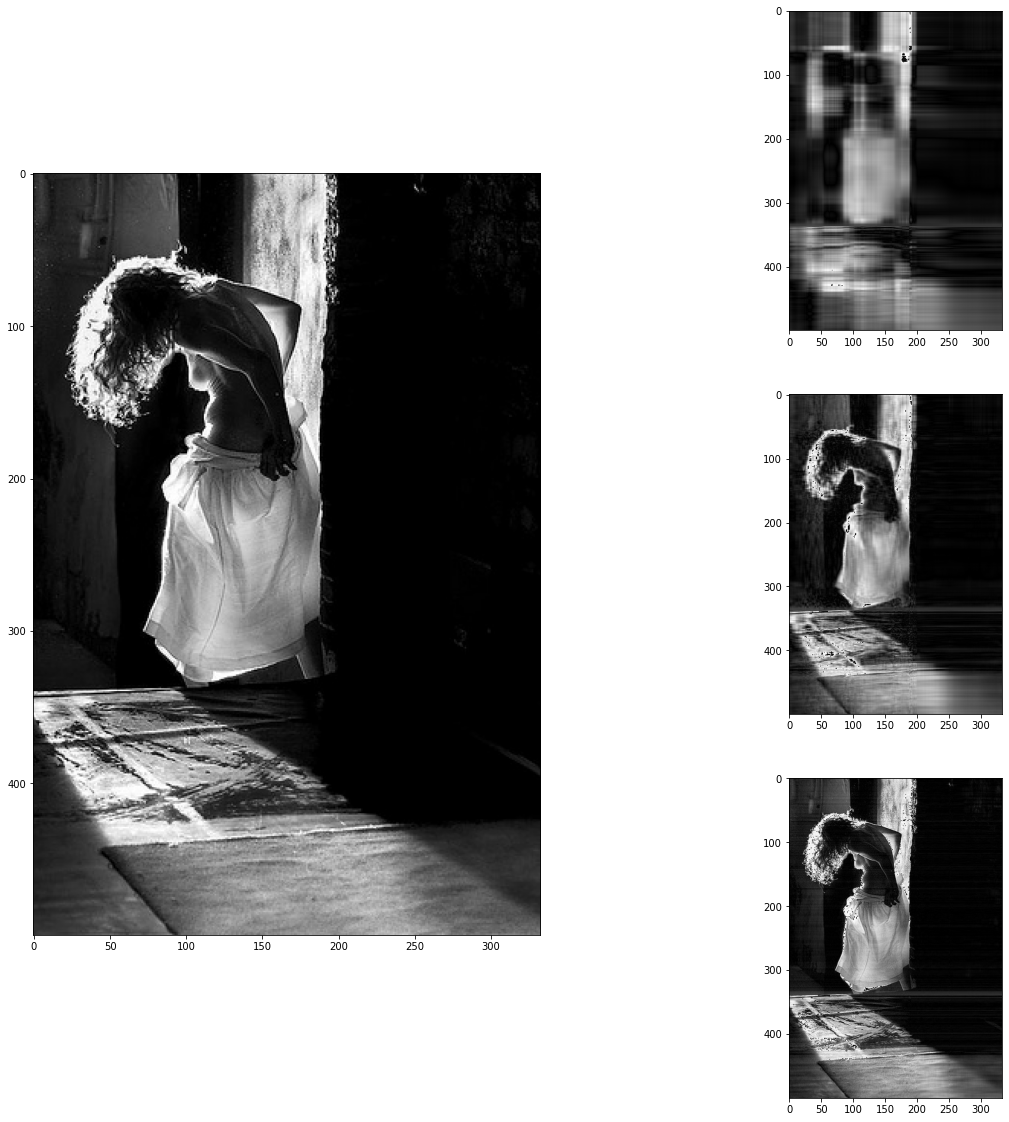

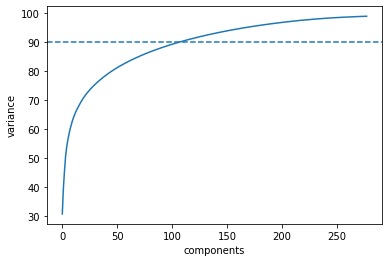

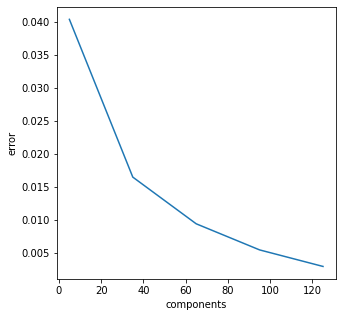

In [20]:
red, green, blue = get_decompose()
get_graphics()

6. Провести моделювання окремих каналів кольору зображень з використанням марковських ланцюгів: a. Для кожного каналу кольору кожного зображення розрахувати стохастическую матрицю марковської ланцюга першого і другого порядків (обробка пікселів по горизонталі справа наліво і навпаки, а також по вертикалі зверху вниз і навпаки). У звіті привести явний вигляд однієї марковської ланцюга для одного з каналів кольору тестового зображення; b. Перевірити властивість регулярності, реккурентное і незворотності (irreducible) для отриманих марковских моделей для 5 ітерацій.

In [27]:
def get_transition(array, order):
    
    _shape = (max(array) + 1,) * (order + 1)
    M = np.zeros(_shape)

    for _ind in zip(*[array[_x:] for _x in range(order + 1)]):
        M[_ind] += 1
        
    return np.array(M)

def get_tran(images, order):
    
    result = []
    for i in images:
        TM_vert = []
        TM_hor = []
        for x in range(i.shape[0]):
            hor = np.array(list(reversed(i[x,:])))
            hor_tran = get_transition(hor,order)
            TM_hor.append(hor_tran)
        for y in range(i.shape[1]):
            vert = np.array(list(reversed(i[:,y])))
            vert_tran = get_transition(vert,order)
            TM_vert.append(vert_tran)
        TM_vert = np.array(TM_vert)
        TM_hor = np.array(TM_hor)
        result.append(list((TM_vert,TM_hor)))
        
    return np.array(result)

def get_matrix_and_graph():
    
    first_order = get_tran(df['data'][:10], 1)
    second_order = get_tran(df['data'][:10], 2)
    states = [tuple(i) for i in list(reversed(df['data'][:10][:,0]))]
    labels= {}
    edge_labels= {}
    for i, origin in enumerate(states):
        for j, dest in enumerate(states):
            rate = get_tran(states,1)[i][j]
            if rate > 0:
                (nx.MultiDiGraph()).add_edge(origin, dest,
                       weight=rate,
                       label="{:.02f}".format(rate))
                edge_labels[(origin_state, destination_state)] = label="{:.02f}".format(rate)
    plt.figure(figsize=(14,7))
    node_size = 200
    nx.draw_networkx_edges(nx.MultiDiGraph(), {state:list(state) for state in states}, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(nx.MultiDiGraph(), {state:list(state) for state in states}, font_weight=2)
    nx.draw_networkx_edge_labels(nx.MultiDiGraph(), {state:list(state) for state in states}, edge_labels)
    plt.axis('off')
    n = np.array(get_transition(np.array(list(reversed(df['data'][34][:, 5]))),1))
    for row in n: print(' '.join('{0:.2f}'.format(x) for x in row))

In [31]:
def get_final_graph():

    test_list = [red, green, blue]
    col = ['RED', 'GREEN', 'BLUE']
    c = 0
    for color in test_list:
        matrix1 = np.zeros(shape=(256, 256))
        array = color.flatten('F')
        prev_color = array[0]
        for i in range(len(array) - 1):
            matrix1[array[i]][array[i + 1]] += 1
        matrix = matrix1[0] / sum(matrix1[0])
        for i in range(1, 256):
            matrix = np.vstack((matrix, matrix1[i] / sum(matrix1[i])))   
        print(f'matrix for {col[c]} first oder:\n', matrix)
        print(f'\nmatrix for {col[c]} second order:\n', np.linalg.matrix_power(matrix, 2))
        c +=1
    data = np.triu(matrix) + np.triu(matrix).T
    index = [str(i) for i in range(data.shape[0])]
    dataframe = pd.DataFrame(data, index=index, columns=index)
    plt.figure(1,figsize=(12,12))  
    g = nx.from_pandas_adjacency(dataframe)
    nx.draw(g, with_labels=True)
    plt.show()

matrix for RED first oder:
 [[9.18126894e-01 4.07106962e-02 1.25915191e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.70464135e-01 3.72320675e-01 9.97468354e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.24806202e-01 2.07280081e-01 2.34917425e-01 ... 3.37040782e-04
  0.00000000e+00 0.00000000e+00]
 ...
 [4.36681223e-03 0.00000000e+00 0.00000000e+00 ... 6.11353712e-02
  5.67685590e-02 1.74672489e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.88349515e-02
  6.14886731e-02 1.74757282e-01]
 [1.25156446e-03 0.00000000e+00 0.00000000e+00 ... 5.13141427e-02
  7.25907384e-02 1.40175219e-01]]

matrix for RED second order:
 [[8.63067158e-01 5.68372577e-02 2.05794218e-02 ... 6.66646515e-06
  4.49647126e-06 1.63972353e-05]
 [5.13856549e-01 1.84815901e-01 7.74790787e-02 ... 5.43575622e-05
  2.46471281e-05 8.41645619e-05]
 [3.66743940e-01 1.58949540e-01 1.06992452e-01 ... 1.18214852e-04
  3.44197501e-05 1.22908745e-04]
 ...
 [6.16950789e-03 5.44082039e-04 4.81787

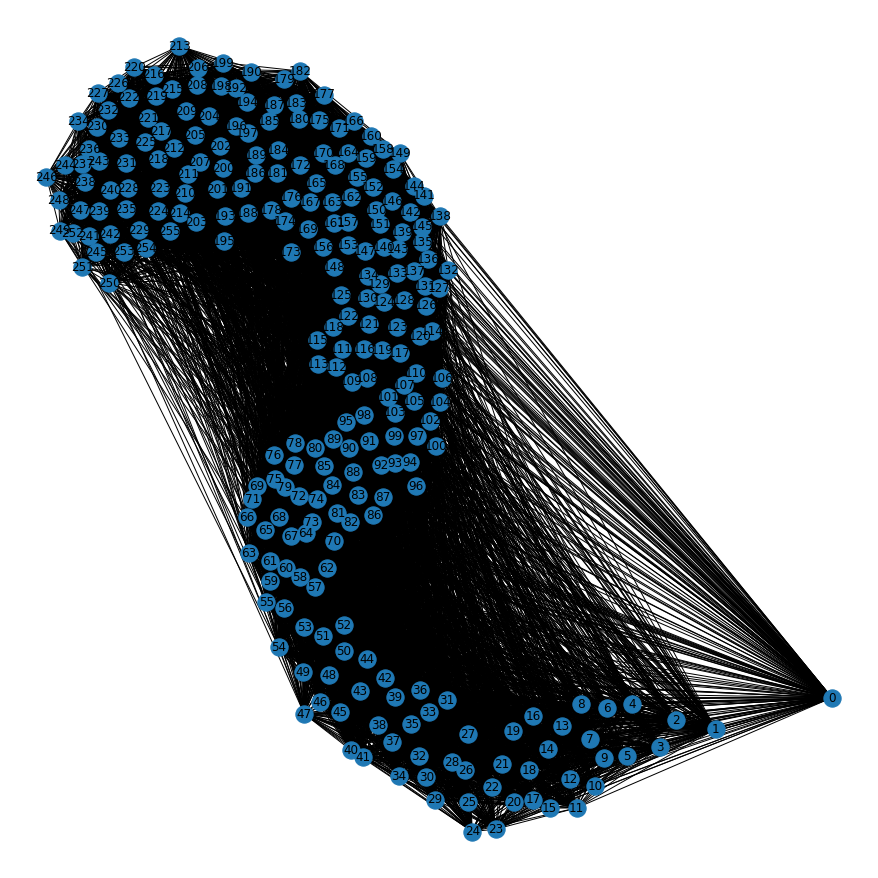

In [32]:
get_final_graph()